In [ ]:
import numpy as np
import glob
import cv2
import os
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import shutil
from tensorflow.keras import models

In [ ]:
# From the pictures provided, identify the faces on them and crop the face portion
# This process is the same process used to load data to train the models

cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml" 
face_cascade = cv2.CascadeClassifier(cascade_path)

raw_imgs = glob.glob("/content/drive/MyDrive/PICS_FOR_TEST/*") # folder containing the raw images provided
raw_imgs.sort()
img_filename = []
test_images_input = [] # list to collect the cropped images, it may contain more than one result per raw image providede

for img in raw_imgs:
  img_name = os.path.basename(img)
  img = cv2.imread(img)
  faces = face_cascade.detectMultiScale(img, 1.1, 3, minSize=(100,100))
  
  if (faces is None):
    continue
  else:
    for (x, y, w, h) in faces:
      r = max(w, h) / 2
      if y <= 80:          # to avoid out of bonds error when shifting the crop upward
        centerx = x + w / 2
        centery = y-y + h / 2
        nx = int(centerx - r)
        ny = int(centery - r + y)
        nr = int(r * 2)
      else:
        centerx = x + w / 2
        centery = y-80 + h / 2 # shifting the crop upward to obtain the hair
        nx = int(centerx - r)
        ny = int(centery - r)
        nr = int(r * 2)

      faceimg = img[ny:ny+nr, nx:nx+nr]
      lastimg = cv2.resize(faceimg, (224, 224))
      lastimg_rgb = cv2.cvtColor(lastimg, cv2.COLOR_BGR2RGB)
      test_images_input.append(lastimg_rgb)
      img_filename.append(img_name)
   
images_test = np.array(test_images_input)

In [ ]:
model_wr = models.load_model('/content/drive/MyDrive/model/model_wrinkles')
model_fr = models.load_model('/content/drive/MyDrive/model/model_freakles')
model_gl = models.load_model('/content/drive/MyDrive/model/model_glasses')
model_hc = models.load_model('/content/drive/MyDrive/model/model_hair_color')
model_ht = models.load_model('/content/drive/MyDrive/model/model_hair_top')

In [ ]:
wr_pred = model_wr.predict(images_test)
fr_pred = model_fr.predict(images_test)
gl_pred = model_gl.predict(images_test)
hc_pred = model_hc.predict(images_test)
ht_pred = model_ht.predict(images_test)

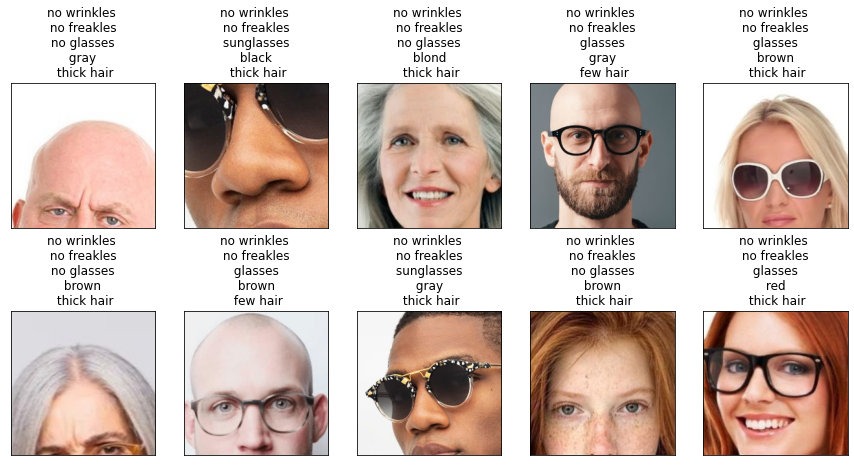

In [ ]:
wrinkles_x = ["no wrinkles", "wrinkles"]
freakles_x = ["no freakles", "freakles"]
glasses_x = ["no glasses", "glasses", "sunglasses"]
hair_color_x = ["brown", "black", "gray", "blond", "red", "white", "mixed", "other", "not visible"]
hair_top_x = ["bald/shaved", "few hair", "thick hair", "not visible"]

# Plot a random sample of 15 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(15, 8))
for i, index in enumerate(np.random.choice(images_test.shape[0], size=10, replace=False)):
    ax = figure.add_subplot(2, 5, i +1 , xticks=[], yticks=[])
    plt.subplots_adjust(hspace = 0.1)
    # Display each image
    ax.imshow(np.squeeze(images_test[index])) # to show the correct picture
    predict_index0 = np.argmax(wr_pred[index])
    predict_index1 = np.argmax(fr_pred[index])
    predict_index2 = np.argmax(gl_pred[index])
    predict_index3 = np.argmax(hc_pred[index])
    predict_index4 = np.argmax(ht_pred[index])
    # Set the title for each image
    ax.set_title("{} \n {} \n {} \n {} \n {}".format( 
                                  wrinkles_x[predict_index0],
                                  freakles_x[predict_index1],                                  
                                  glasses_x[predict_index2],                                 
                                  hair_color_x[predict_index3],                                 
                                  hair_top_x[predict_index4],))

In [ ]:
predictions = []

for index in range(len(img_filename)):
  predictions.append([img_filename[index],
                      np.argmax(wr_pred[index]),
                      np.argmax(fr_pred[index]),
                      np.argmax(gl_pred[index]),
                      np.argmax(hc_pred[index]),
                      np.argmax(ht_pred[index])])

#Create predictions file for CW deliverable

with open('/content/drive/MyDrive/predictions.csv', 'w') as f: 
  # using csv.writer method from CSV package
  write = csv.writer(f)      
  write.writerow(('image_name','wrinkles','freakles','glasses','hair_color','hair_top'))
  write.writerows(predictions)
